In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

In [56]:
data = pd.read_csv('date_tema_1_iaut_2024.csv')

In [57]:
preprocessed_data = data.copy()

numeric_features = ['Regular_fiber_diet', 'Sedentary_hours_daily', 'Age', 'Est_avg_calorie_intake', 'Main_meals_daily', 'Height', 'Water_daily', 'Weight', 'Physical_activity_level', 'Technology_time_use']
string_features = ['Transportation', 'Alcohol', 'Snacks', 'Gender']
bool_feature = ['Diagnostic_in_family_history', 'High_calorie_diet', 'Smoker', 'Calorie_monitoring']
class_feature = ['Diagnostic']

for feature in numeric_features:
    if preprocessed_data[feature].dtype == type(object):
        preprocessed_data[feature] = preprocessed_data[feature].str.replace(',', '.').astype(float)

for feature in string_features + bool_feature + class_feature:
        le = LabelEncoder()
        preprocessed_data[feature] = le.fit_transform(data[feature])

for feature in numeric_features:
    q1 = preprocessed_data[feature].quantile(0.25)
    q3 = preprocessed_data[feature].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    preprocessed_data = preprocessed_data[(preprocessed_data[feature] > lower_bound) & (preprocessed_data[feature] < upper_bound)]

imputer = SimpleImputer(strategy='mean', missing_values=-1)
preprocessed_data['Weight'] = imputer.fit_transform(preprocessed_data[['Weight']])

## 3.1 Explorarea datelor

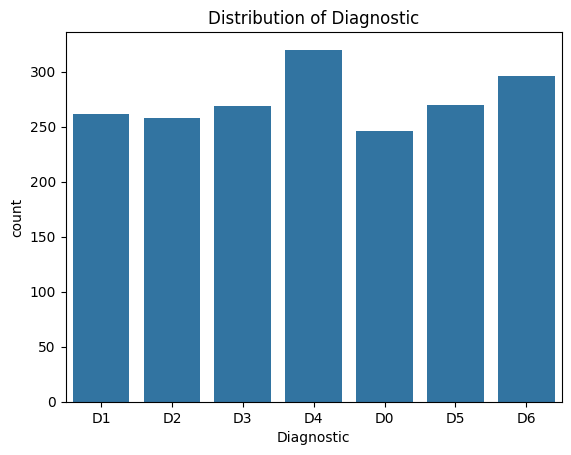

In [58]:
for feature in class_feature:
    plt.figure()
    sns.countplot(x='Diagnostic', data=data, order=data['Diagnostic'].unique())
    plt.title(f'Distribution of {feature}')
    plt.show()

In [59]:
preprocessed_data[numeric_features].describe()

,Regular_fiber_diet,Sedentary_hours_daily,Age,Est_avg_calorie_intake,Main_meals_daily,Height,Water_daily,Weight,Physical_activity_level,Technology_time_use
count,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000
mean,2.457411,3.232889,23.146854,2255.551587,2.968345,1.715198,2.055486,92.245200,1.041277,0.717460
std,0.550190,0.562610,4.158762,434.169456,0.149404,0.086743,0.602287,25.949752,0.859349,0.655772
min,1.000000,2.210000,15.000000,1500.000000,2.217651,1.460000,1.000000,39.000000,0.000000,0.000000
25%,2.000000,2.847500,19.922719,1868.000000,3.000000,1.650000,1.706230,74.750000,0.139646,0.000000
50%,2.561869,3.180000,22.774751,2258.000000,3.000000,1.720000,2.000000,92.245200,1.000000,1.000000
75%,3.000000,3.650000,25.988985,2634.250000,3.000000,1.780000,2.552590,111.927926,1.665139,1.000000
max,3.000000,4.660000,35.000000,2998.000000,3.471536,1.940000,3.000000,165.057269,3.000000,2.000000


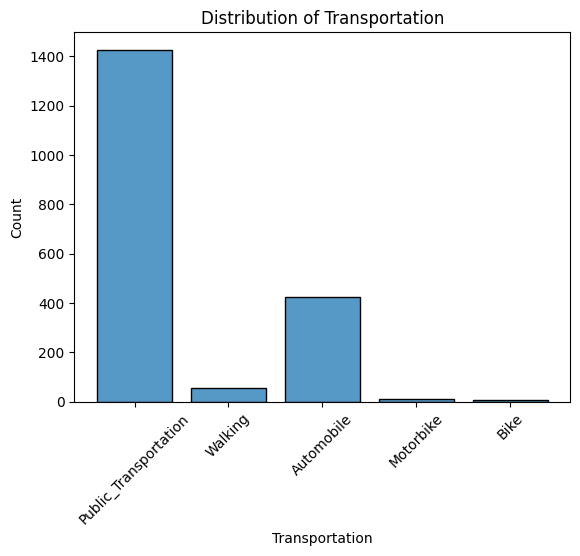

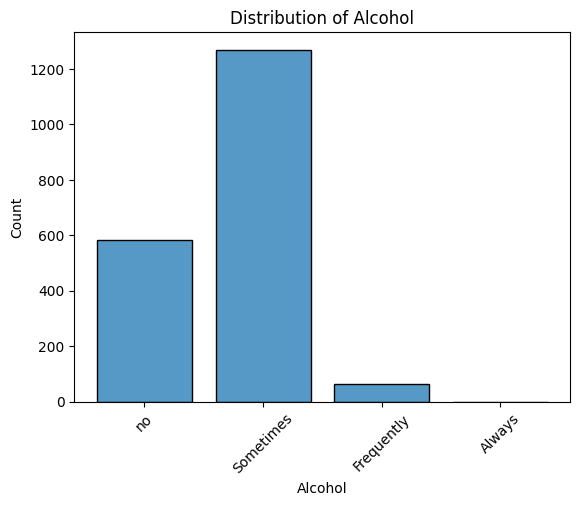

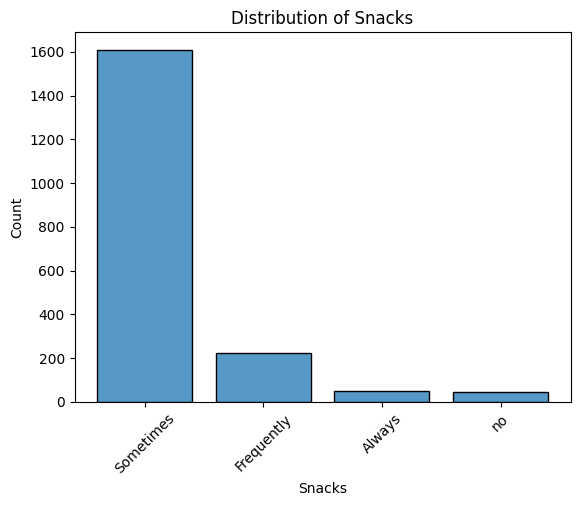

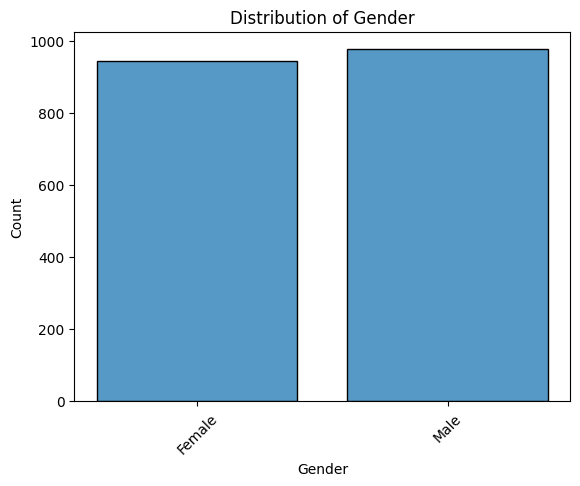

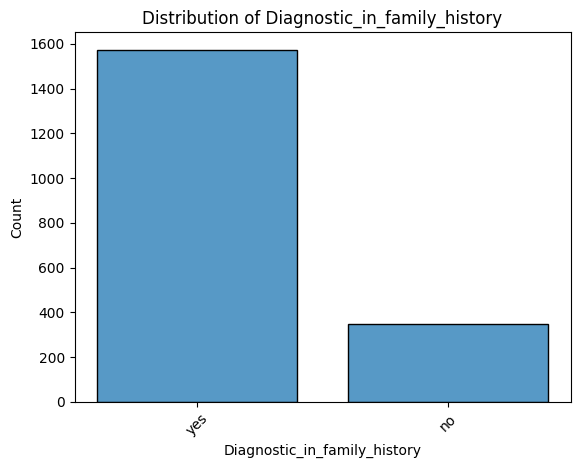

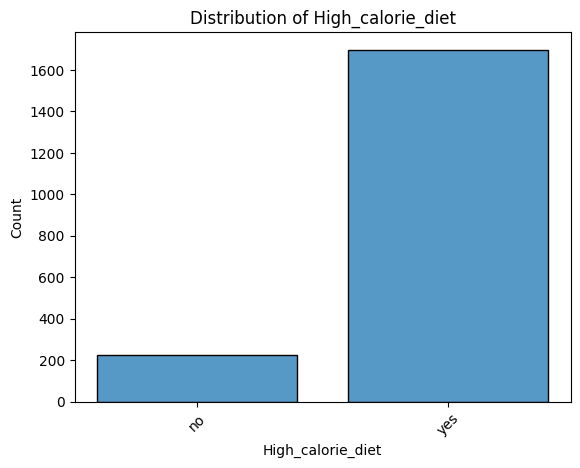

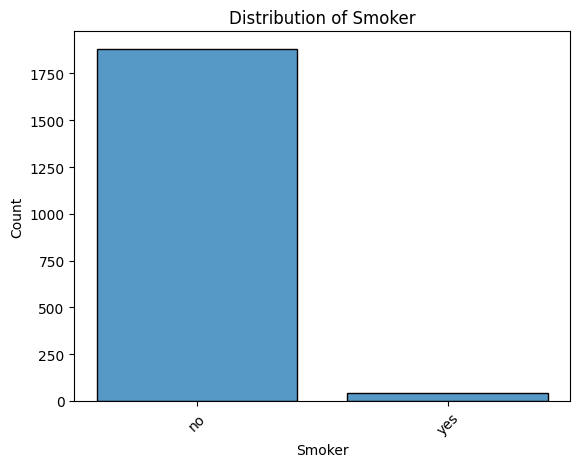

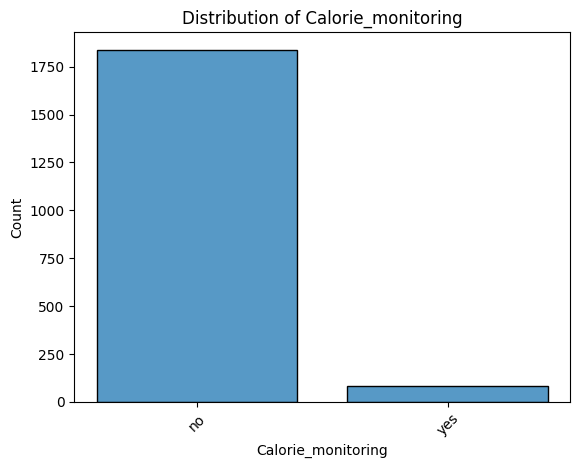

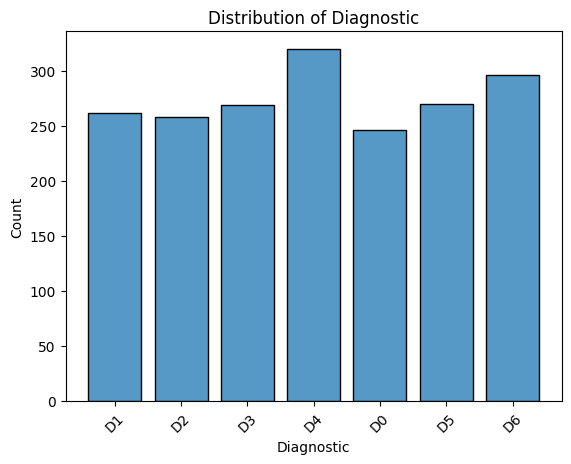

In [60]:
for feature in string_features + bool_feature + class_feature:
    plt.figure()
    sns.histplot(data[feature], kde=False, shrink=0.8)
    plt.title(f'Distribution of {feature}')
    plt.xticks(rotation=45)
    plt.show()

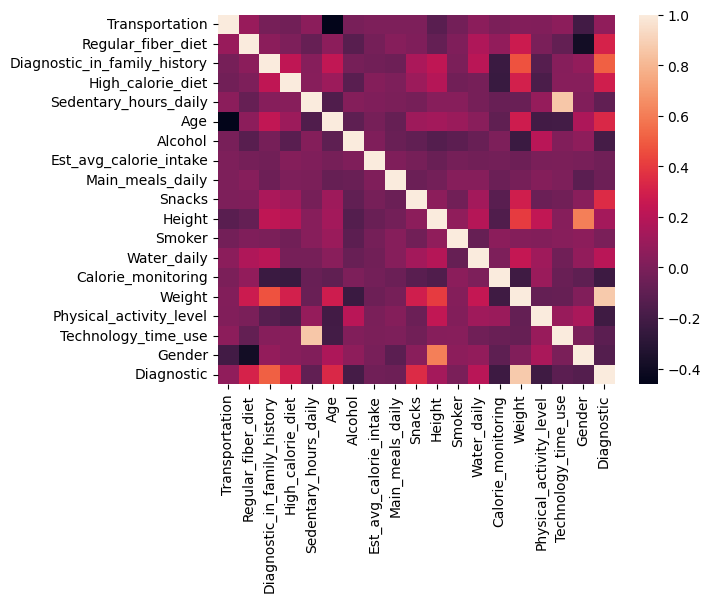

In [61]:
axes = sns.heatmap(preprocessed_data.corr())

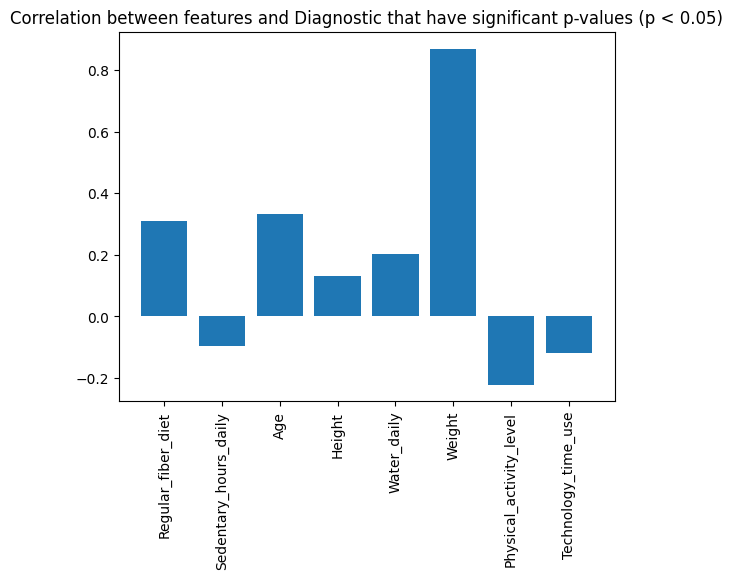

In [62]:
p_values = [stats.pointbiserialr(preprocessed_data['Diagnostic'], preprocessed_data[feature]) for feature in numeric_features]
aux = zip(numeric_features, p_values)
aux = list(filter(lambda x: x[1][1] < 0.05, aux))

plt.figure()
plt.bar(list(map(lambda x: x[0], aux)), list(map(lambda x: x[1][0], aux)))
plt.xticks(rotation=90)
plt.title('Correlation between features and Diagnostic that have significant p-values (p < 0.05)')
plt.show()

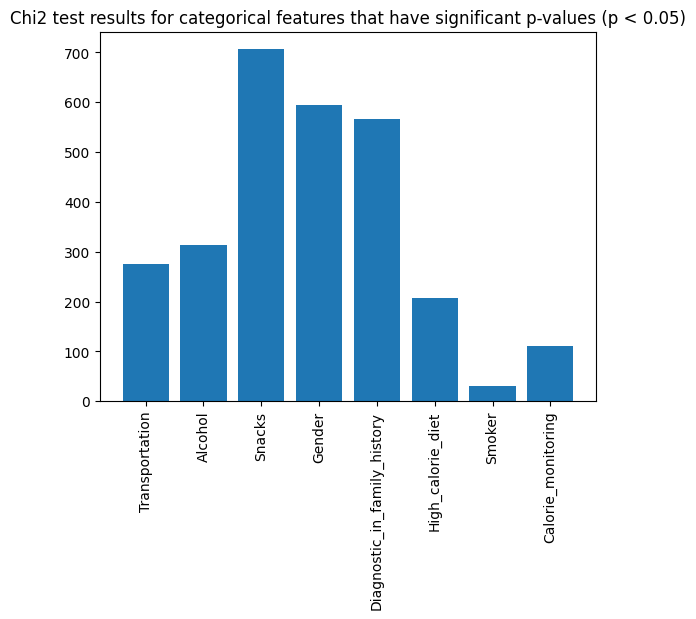

In [63]:
chi_values = [stats.chi2_contingency(pd.crosstab(data['Diagnostic'], data[feature])) for feature in string_features + bool_feature]
aux = zip(string_features + bool_feature, chi_values)
aux = list(filter(lambda x: x[1][1] < 0.05, aux))

plt.figure()
plt.bar(list(map(lambda x: x[0], aux)), list(map(lambda x: x[1][0], aux)))
plt.xticks(rotation=90)
plt.title('Chi2 test results for categorical features that have significant p-values (p < 0.05)')
plt.show()

## 3.2 Utilizarea algoritmilor clasici de Învățare Automată cu intreg setul de features

In [64]:
from sklearn.preprocessing import MinMaxScaler

#Normalizing the data ni order to be able to use it in the models as some columns have means of 3 orders of magnitude higher than others
scaler = MinMaxScaler()
normalized_data = pd.DataFrame(scaler.fit_transform(preprocessed_data), columns=preprocessed_data.columns)

In [65]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
import xgboost as xgb

In [66]:
X = normalized_data.drop(columns=['Diagnostic'])
y = preprocessed_data['Diagnostic']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Random Forest Classifers

In [67]:
random_forest_model = RandomForestClassifier(random_state=42)
params = {
    'n_estimators': [10, 50, 100, 500],
    'max_depth': [3, 5, 10, 15, 18],
    'max_samples': [0.1, 0.25, 0.5, 0.75, 1.0],
}

search = GridSearchCV(estimator=random_forest_model, param_grid=params, cv=5)
search.fit(X_train, y_train)

print("RandomForestClassifier Best Parameters:", search.best_params_)
print("Best score:", search.best_score_)

RandomForestClassifier Best Parameters: {'max_depth': 10, 'max_samples': 1.0, 'n_estimators': 500}
Best score: 0.9107186838086795


### Extra Tree Classifiers

In [68]:
extra_trees_model = ExtraTreesClassifier(bootstrap=True, random_state=42)
params = {
    'n_estimators': [10, 50, 100, 500],
    'max_depth': [3, 5, 10, 15, 18],
    'max_samples': [0.1, 0.25, 0.5, 0.75, 1.0],
}

search = GridSearchCV(estimator=extra_trees_model, param_grid=params, cv=5)
search.fit(X_train, y_train)

print("ExtraTreesClassifier Best Parameters:", search.best_params_)
print("Best score:", search.best_score_)

ExtraTreesClassifier Best Parameters: {'max_depth': 18, 'max_samples': 1.0, 'n_estimators': 500}
Best score: 0.8987980887641003


### SVM

In [69]:
svc = SVC(random_state=42)
params = {
    'C': [0.1, 1, 10, 100, 1000, 10000],
    'kernel': ['linear', 'rbf', 'sigmoid'],
}

search = GridSearchCV(estimator=svc, param_grid=params, cv=5)
search.fit(X_train, y_train)

print("SVC Best Parameters:", search.best_params_)
print("Best score:", search.best_score_)


poly_svc = SVC(kernel='poly', random_state=42)
params = {
    'C': [0.1, 1, 10, 100, 1000, 10000],
    'degree': [2, 3, 4, 5]
}

search = GridSearchCV(estimator=poly_svc, param_grid=params, cv=5)
search.fit(X_train, y_train)

print("SVC Best Parameters For Poly SVC:", search.best_params_)
print("Best score for Poly SVC:", search.best_score_)

SVC Best Parameters: {'C': 1000, 'kernel': 'linear'}
Best score: 0.8283828382838283
SVC Best Parameters For Poly SVC: {'C': 10, 'degree': 2}
Best score for Poly SVC: 0.8264124919954682


### XGB

In [70]:
xgbb = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
params = {
    'n_estimators': [10, 50, 100, 500],
    'max_depth': [3, 5, 10, 15, 18],
    'learning_rate': [0.1, 0.01, 0.001],
}

search = GridSearchCV(estimator=xgbb, param_grid=params, cv=5)
search.fit(X_train, y_train)

print("XGB Best Parameters:", search.best_params_)
print("Best score:", search.best_score_)

XGB Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
Best score: 0.9196246490320675


## 3.3 Utilizarea algoritmilor clasici de Învățare Automată doar cu feature-urile cele mai importante conform statisticilor din p-test si chi-squared-test

In [71]:
feature_selection = normalized_data[['Snacks', 'Gender', 'Diagnostic_in_family_history', 'Weight', 'Age', 'Physical_activity_level']]
X = feature_selection
y = preprocessed_data['Diagnostic']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Random Forest Classifers

In [72]:
random_forest_model = RandomForestClassifier(random_state=42)
params = {
    'n_estimators': [10, 50, 100, 500],
    'max_depth': [3, 5, 10, 15, 18],
    'max_samples': [0.1, 0.25, 0.5, 0.75, 1.0],
}

search = GridSearchCV(estimator=random_forest_model, param_grid=params, cv=5)
search.fit(X_train, y_train)

print("RandomForestClassifier Best Parameters:", search.best_params_)
print("Best score:", search.best_score_)

RandomForestClassifier Best Parameters: {'max_depth': 15, 'max_samples': 0.75, 'n_estimators': 500}
Best score: 0.8442687552337323


### Extra Tree Classifiers

In [73]:
extra_trees_model = ExtraTreesClassifier(bootstrap=True, random_state=42)
params = {
    'n_estimators': [10, 50, 100, 500],
    'max_depth': [3, 5, 10, 15, 18],
    'max_samples': [0.1, 0.25, 0.5, 0.75, 1.0],
}

search = GridSearchCV(estimator=extra_trees_model, param_grid=params, cv=5)
search.fit(X_train, y_train)

print("ExtraTreesClassifier Best Parameters:", search.best_params_)
print("Best score:", search.best_score_)

ExtraTreesClassifier Best Parameters: {'max_depth': 15, 'max_samples': 0.75, 'n_estimators': 100}
Best score: 0.8333185557361705


### SVM

In [74]:
svc = SVC(random_state=42)
params = {
    'C': [0.1, 1, 10, 100, 1000, 10000],
    'kernel': ['linear', 'rbf', 'sigmoid'],
}

search = GridSearchCV(estimator=svc, param_grid=params, cv=5)
search.fit(X_train, y_train)

print("SVC Best Parameters:", search.best_params_)
print("Best score:", search.best_score_)


poly_svc = SVC(kernel='poly', random_state=42)
params = {
    'C': [0.1, 1, 10, 100, 1000, 10000],
    'degree': [2, 3, 4, 5]
}

search = GridSearchCV(estimator=poly_svc, param_grid=params, cv=5)
search.fit(X_train, y_train)

print("SVC Best Parameters For Poly SVC:", search.best_params_)
print("Best score for Poly SVC:", search.best_score_)

SVC Best Parameters: {'C': 10000, 'kernel': 'rbf'}
Best score: 0.7638934042657998
SVC Best Parameters For Poly SVC: {'C': 1000, 'degree': 4}
Best score for Poly SVC: 0.7728092212206296


### XGB

In [75]:
xgbb = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
params = {
    'n_estimators': [10, 50, 100, 500],
    'max_depth': [3, 5, 10, 15, 18],
    'learning_rate': [0.1, 0.01, 0.001],
}

search = GridSearchCV(estimator=xgbb, param_grid=params, cv=5)
search.fit(X_train, y_train)

print("XGB Best Parameters:", search.best_params_)
print("Best score:", search.best_score_)

XGB Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
Best score: 0.8482094478104527


## 3.4 Utilizarea algoritmilor clasici de Învățare Automată doar cu feature-urile cele mai importante conform statisticilor din p-test si chi-squared-test la care adaugam cateva feature-uri mai putin importante

In [76]:
feature_selection = normalized_data[['Snacks', 'Gender', 'Diagnostic_in_family_history', 'Weight', 'Age', 'Physical_activity_level', 'Water_daily', 'Transportation', 'Alcohol']]
X = feature_selection
y = preprocessed_data['Diagnostic']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Random Forest Classifers

In [77]:
random_forest_model = RandomForestClassifier(random_state=42)
params = {
    'n_estimators': [10, 50, 100, 500],
    'max_depth': [3, 5, 10, 15, 18],
    'max_samples': [0.1, 0.25, 0.5, 0.75, 1.0],
}

search = GridSearchCV(estimator=random_forest_model, param_grid=params, cv=5)
search.fit(X_train, y_train)

print("RandomForestClassifier Best Parameters:", search.best_params_)
print("Best score:", search.best_score_)

RandomForestClassifier Best Parameters: {'max_depth': 18, 'max_samples': 1.0, 'n_estimators': 500}
Best score: 0.877976454361854


### Extra Tree Classifiers

In [78]:
extra_trees_model = ExtraTreesClassifier(bootstrap=True, random_state=42)
params = {
    'n_estimators': [10, 50, 100, 500],
    'max_depth': [3, 5, 10, 15, 18],
    'max_samples': [0.1, 0.25, 0.5, 0.75, 1.0],
}

search = GridSearchCV(estimator=extra_trees_model, param_grid=params, cv=5)
search.fit(X_train, y_train)

print("ExtraTreesClassifier Best Parameters:", search.best_params_)
print("Best score:", search.best_score_)

ExtraTreesClassifier Best Parameters: {'max_depth': 18, 'max_samples': 1.0, 'n_estimators': 100}
Best score: 0.8640904388946357


### SVM

In [79]:
svc = SVC(random_state=42)
params = {
    'C': [0.1, 1, 10, 100, 1000, 10000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
}

search = GridSearchCV(estimator=svc, param_grid=params, cv=5)
search.fit(X_train, y_train)

print("SVC Best Parameters:", search.best_params_)
print("Best score:", search.best_score_)


poly_svc = SVC(kernel='poly', random_state=42)
params = {
    'C': [0.1, 1, 10, 100, 1000, 10000],
    'degree': [2, 3, 4, 5]
}

search = GridSearchCV(estimator=poly_svc, param_grid=params, cv=5)
search.fit(X_train, y_train)

print("SVC Best Parameters For Poly SVC:", search.best_params_)
print("Best score for Poly SVC:", search.best_score_)

SVC Best Parameters: {'C': 1000, 'kernel': 'rbf'}
Best score: 0.7926949411359046
SVC Best Parameters For Poly SVC: {'C': 10, 'degree': 2}
Best score for Poly SVC: 0.7778139007930644


### XGB

In [80]:
xgbb = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
params = {
    'n_estimators': [10, 50, 100, 500],
    'max_depth': [3, 5, 10, 15, 18],
    'learning_rate': [0.1, 0.01, 0.001],
}

search = GridSearchCV(estimator=xgbb, param_grid=params, cv=5)
search.fit(X_train, y_train)

print("XGB Best Parameters:", search.best_params_)
print("Best score:", search.best_score_)

XGB Best Parameters: {'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 500}
Best score: 0.8729865523865818
